In [1]:
%cd C:\mimic-iv-2.2\mimic-iv-2.2\hosp

C:\mimic-iv-2.2\mimic-iv-2.2\hosp


In [3]:
import pandas as pd

In [7]:
df_d_icd_diagnoses = pd.read_csv('d_icd_diagnoses.csv')

In [6]:
df_diagnoses_icd = pd.read_csv("diagnoses_icd.csv")

In [8]:
# 고혈압 진단 코드 정규식
high_bp_regex = r'^I1[0-5]$|^401'

#암 진단 코드 정규식  
#ICD-9 코드 분류 (140-239)
#ICD-10 코드 분류 (C00-C96, D00-D09)
cancer_regex = r'^(D(0[0-9])|C([0-8][0-9]|9[0-6])|(1[4-9][0-9]|2[0-3][0-9])).*'


# 암 진단 코드 추출
cancer_df = df_diagnoses_icd[df_diagnoses_icd['icd_code'].str.match(cancer_regex)]

# 암 진단을 받은 환자 ID 추출
cancer_patient_ids = cancer_df['subject_id'].unique()

# 암 진단을 받은 환자들의 데이터 추출
cancer_diagnoses_merged = pd.merge(df_diagnoses_icd, df_d_icd_diagnoses, on=['icd_code'])
cancer_patients_data = cancer_diagnoses_merged[cancer_diagnoses_merged['subject_id'].isin(cancer_patient_ids)]



# 암 및 고혈압을 동시에 가진 환자들의 데이터 추출 (첫 번째 진단만 포함)
cancer_high_bp_ids = cancer_patients_data[cancer_patients_data['icd_code'].str.match(high_bp_regex)]['subject_id'].unique()
cancer_high_bp_df = cancer_diagnoses_merged[(cancer_diagnoses_merged['subject_id'].isin(cancer_high_bp_ids)) & 
                                            (cancer_diagnoses_merged['seq_num'] == 1) & 
                                            (cancer_diagnoses_merged['icd_code'].str.match(cancer_regex))]

cancer_high_bp_df

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,icd_version_y,long_title
393337,10071129,25200387,1,1890,9,9,"Malignant neoplasm of kidney, except pelvis"
393339,10094971,20200109,1,1890,9,9,"Malignant neoplasm of kidney, except pelvis"
393351,10171405,23985269,1,1890,9,9,"Malignant neoplasm of kidney, except pelvis"
393356,10171405,29677692,1,1890,9,9,"Malignant neoplasm of kidney, except pelvis"
393364,10322775,24742385,1,1890,9,9,"Malignant neoplasm of kidney, except pelvis"
...,...,...,...,...,...,...,...
4859732,19128927,28814179,1,C44692,10,10,Other specified malignant neoplasm of skin of ...
4859827,19282415,28695316,1,C004,10,10,"Malignant neoplasm of lower lip, inner aspect"
4859828,19290501,28187167,1,C8468,10,10,"Anaplastic large cell lymphoma, ALK-positive, ..."
4860174,19851929,29152819,1,1643,9,9,Malignant neoplasm of posterior mediastinum


In [9]:
# subject_id로 그룹화하고 각 그룹에서 hadm_id가 가장 작은 행 선택
result = cancer_high_bp_df.loc[cancer_high_bp_df.groupby('subject_id')['hadm_id'].idxmin()]

# 필요시 인덱스 리셋
result.reset_index(drop=True, inplace=True)

In [10]:
df_patients = pd.read_csv("patients.csv")

In [11]:
merge2 = pd.merge(result,df_patients, on=['subject_id'])
merge2

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,icd_version_y,long_title,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10001401,21544441,1,C675,10,10,Malignant neoplasm of bladder neck,F,89,2131,2014 - 2016,NaN
1,10001877,25679292,1,2252,9,9,Benign neoplasm of cerebral meninges,M,89,2149,2008 - 2010,NaN
2,10002155,20345487,1,1628,9,9,Malignant neoplasm of other parts of bronchus ...,F,80,2128,2008 - 2010,2131-03-10
3,10002348,22725460,1,C7931,10,10,Secondary malignant neoplasm of brain,F,77,2112,2017 - 2019,NaN
4,10003400,20214994,1,1543,9,9,"Malignant neoplasm of anus, unspecified site",F,72,2134,2011 - 2013,2137-09-02
...,...,...,...,...,...,...,...,...,...,...,...,...
9183,19996783,22140408,1,C259,10,10,"Malignant neoplasm of pancreas, unspecified",M,89,2188,2017 - 2019,2188-05-21
9184,19997538,22701415,1,C20,10,10,Malignant neoplasm of rectum,M,53,2168,2017 - 2019,NaN
9185,19999204,29046609,1,C220,10,10,Liver cell carcinoma,M,61,2146,2017 - 2019,2146-08-29
9186,19999287,22997012,1,1629,9,9,"Malignant neoplasm of bronchus and lung, unspe...",F,71,2191,2008 - 2010,2197-09-02


In [14]:
df_admission = pd.read_csv("admissions.csv")
merge2_admission = pd.merge(merge2,df_admission, on=['subject_id','hadm_id'])
merge2_admission

,subject_id,hadm_id,seq_num,icd_code,icd_version_x,icd_version_y,long_title,gender,anchor_age,anchor_year,...,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10001401,21544441,1,C675,10,10,Malignant neoplasm of bladder neck,F,89,2131,...,P872K3,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,NaN,NaN,0
1,10001877,25679292,1,2252,9,9,Benign neoplasm of cerebral meninges,M,89,2149,...,P47KFL,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,ENGLISH,MARRIED,WHITE,2149-05-21 10:58:00,2149-05-21 17:15:00,0
2,10002155,20345487,1,1628,9,9,Malignant neoplasm of other parts of bronchus ...,F,80,2128,...,P80515,EMERGENCY ROOM,DIED,Other,ENGLISH,MARRIED,WHITE,2131-03-09 19:14:00,2131-03-09 21:33:00,1
3,10002348,22725460,1,C7931,10,10,Secondary malignant neoplasm of brain,F,77,2112,...,P35WT5,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,2112-11-30 15:08:00,2112-11-30 23:24:00,0
4,10003400,20214994,1,1543,9,9,"Malignant neoplasm of anus, unspecified site",F,72,2134,...,P60ZCO,TRANSFER FROM SKILLED NURSING FACILITY,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9183,19996783,22140408,1,C259,10,10,"Malignant neoplasm of pancreas, unspecified",M,89,2188,...,P878WT,PHYSICIAN REFERRAL,HOME,Other,?,MARRIED,ASIAN - CHINESE,2188-04-22 08:36:00,2188-04-22 19:49:00,0
9184,19997538,22701415,1,C20,10,10,Malignant neoplasm of rectum,M,53,2168,...,P68URZ,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
9185,19999204,29046609,1,C220,10,10,Liver cell carcinoma,M,61,2146,...,P553JT,TRANSFER FROM HOSPITAL,HOME,Medicare,ENGLISH,SINGLE,WHITE,2146-05-30 14:10:00,2146-05-30 20:09:00,0
9186,19999287,22997012,1,1629,9,9,"Malignant neoplasm of bronchus and lung, unspe...",F,71,2191,...,P44WVR,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,2197-07-26 02:51:00,2197-07-26 05:00:00,0


In [15]:
# 출생 연도 계산
print(merge2_admission[['anchor_year','anchor_age']].head(5))
print("~~")

##adgmit_age가 이상한 경우
#  환자의 나이가 89세 이상인 경우, 데이터 보호를 위해 모든 연령이 89세로 고정되어 있다는 것입니다.
merge2_admission = merge2_admission[merge2_admission['anchor_age']<89]

# admittime 열을 datetime 형식으로 변환
merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']

# 입원 연도 추출
admit_year = pd.to_datetime(merge2_admission['admittime']).dt.year

# 입원 시점의 나이 계산
merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']

#인덱스 초기화
merge2_admission.reset_index(drop=True, inplace=True)

#결과확인
print(merge2_admission[['subject_id', 'admittime', 'admit_age','birth_year','anchor_year','anchor_age']].head())

   anchor_year  anchor_age
0         2131          89
1         2149          89
2         2128          80
3         2112          77
4         2134          72
~~
   subject_id            admittime  admit_age  birth_year  anchor_year  \
0    10002155  2131-03-09 20:33:00         83        2048         2128   
1    10002348  2112-11-30 22:22:00         77        2035         2112   
2    10003400  2137-02-24 10:00:00         75        2062         2134   
3    10004235  2196-06-14 08:30:00         47        2149         2196   
4    10005024  2138-03-29 01:17:00         60        2078         2138   

   anchor_age  
0          80  
1          77  
2          72  
3          47  
4          60  


C:\Users\TS\AppData\Local\Temp\ipykernel_2304\4117411835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']
C:\Users\TS\AppData\Local\Temp\ipykernel_2304\4117411835.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']


In [16]:
# 출생 연도 계산
print(merge2_admission[['anchor_year','anchor_age']].head(5))
print("~~")

##adgmit_age가 이상한 경우
#  환자의 나이가 89세 이상인 경우, 데이터 보호를 위해 모든 연령이 89세로 고정되어 있다는 것입니다.
merge2_admission = merge2_admission[merge2_admission['anchor_age']<89]

# admittime 열을 datetime 형식으로 변환
merge2_admission['birth_year'] = merge2_admission['anchor_year'] - merge2_admission['anchor_age']

# 입원 연도 추출
admit_year = pd.to_datetime(merge2_admission['admittime']).dt.year

# 입원 시점의 나이 계산
merge2_admission['admit_age'] = admit_year - merge2_admission['birth_year']

#인덱스 초기화
merge2_admission.reset_index(drop=True, inplace=True)

#결과확인
print(merge2_admission[['subject_id', 'admittime', 'admit_age','birth_year','anchor_year','anchor_age']].head())

   anchor_year  anchor_age
0         2128          80
1         2112          77
2         2134          72
3         2196          47
4         2138          60
~~
   subject_id            admittime  admit_age  birth_year  anchor_year  \
0    10002155  2131-03-09 20:33:00         83        2048         2128   
1    10002348  2112-11-30 22:22:00         77        2035         2112   
2    10003400  2137-02-24 10:00:00         75        2062         2134   
3    10004235  2196-06-14 08:30:00         47        2149         2196   
4    10005024  2138-03-29 01:17:00         60        2078         2138   

   anchor_age  
0          80  
1          77  
2          72  
3          47  
4          60  


In [17]:
merge2_admission = merge2_admission[['subject_id','hadm_id','admit_age','seq_num','gender','dod','deathtime','insurance','language','marital_status','race','hospital_expire_flag','birth_year',]]
merge2_admission

,subject_id,hadm_id,admit_age,seq_num,gender,dod,deathtime,insurance,language,marital_status,race,hospital_expire_flag,birth_year
0,10002155,20345487,83,1,F,2131-03-10,2131-03-10 21:53:00,Other,ENGLISH,MARRIED,WHITE,1,2048
1,10002348,22725460,77,1,F,NaN,NaN,Medicare,ENGLISH,SINGLE,WHITE,0,2035
2,10003400,20214994,75,1,F,2137-09-02,NaN,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,2062
3,10004235,25970245,47,1,M,NaN,NaN,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,0,2149
4,10005024,25023471,60,1,M,2138-04-19,2138-04-19 11:30:00,Medicaid,ENGLISH,SINGLE,UNKNOWN,1,2078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8954,19995127,21801907,83,1,M,2138-06-12,NaN,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,2055
8955,19997538,22701415,53,1,M,NaN,NaN,Other,ENGLISH,MARRIED,WHITE,0,2115
8956,19999204,29046609,61,1,M,2146-08-29,NaN,Medicare,ENGLISH,SINGLE,WHITE,0,2085
8957,19999287,22997012,77,1,F,2197-09-02,NaN,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,0,2120


In [62]:
df_data = merge2_admission
df_data.info()
df_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8959 entries, 0 to 8958
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject_id            8959 non-null   int64 
 1   hadm_id               8959 non-null   int64 
 2   admit_age             8959 non-null   int64 
 3   seq_num               8959 non-null   int64 
 4   gender                8959 non-null   object
 5   dod                   4057 non-null   object
 6   deathtime             350 non-null    object
 7   insurance             8959 non-null   object
 8   language              8959 non-null   object
 9   marital_status        8836 non-null   object
 10  race                  8959 non-null   object
 11  hospital_expire_flag  8959 non-null   int64 
 12  birth_year            8959 non-null   int64 
dtypes: int64(6), object(7)
memory usage: 910.0+ KB


,subject_id,hadm_id,admit_age,seq_num,gender,dod,deathtime,insurance,language,marital_status,race,hospital_expire_flag,birth_year
0,10002155,20345487,83,1,F,2131-03-10,2131-03-10 21:53:00,Other,ENGLISH,MARRIED,WHITE,1,2048
1,10002348,22725460,77,1,F,NaN,NaN,Medicare,ENGLISH,SINGLE,WHITE,0,2035
2,10003400,20214994,75,1,F,2137-09-02,NaN,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,0,2062
3,10004235,25970245,47,1,M,NaN,NaN,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,0,2149
4,10005024,25023471,60,1,M,2138-04-19,2138-04-19 11:30:00,Medicaid,ENGLISH,SINGLE,UNKNOWN,1,2078


In [59]:
#폰트 경로 설정
path= 'C:/Users/TS/Downloads/nanum-all/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

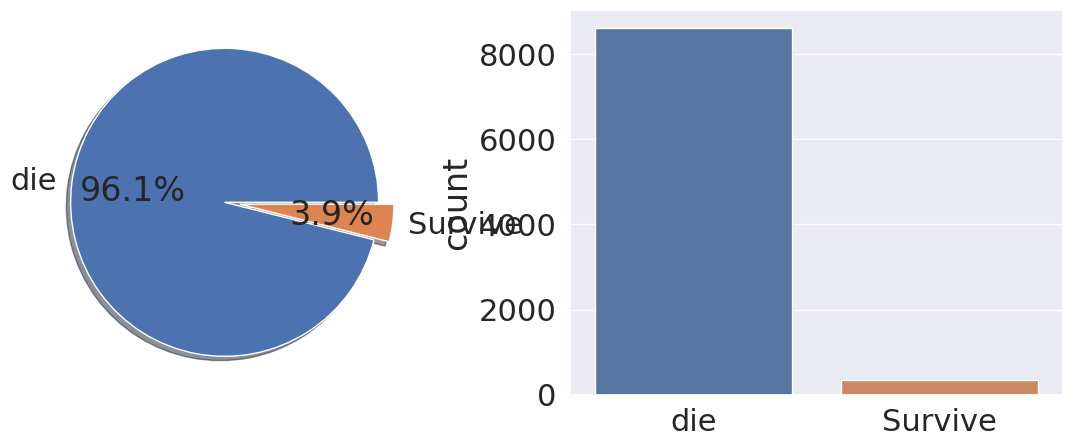

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
labels = ['die', 'Survive']
 
# Pie Plot
df_data['hospital_expire_flag'].value_counts().plot.pie(ax=ax[0], explode=[0,0.1], shadow=True, autopct='%1.1f%%', labels=labels)
ax[0].set(ylabel='')
 
# Count Plot
sns.countplot(data=df_data, x='hospital_expire_flag', ax=ax[1])
ax[1].set(xlabel='', xticklabels=labels)
 
plt.show()

In [63]:
df_data['admit_age'].value_counts()

64    317
65    311
67    306
68    301
66    289
     ... 
24      2
27      2
23      1
95      1
99      1
Name: admit_age, Length: 76, dtype: int64

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

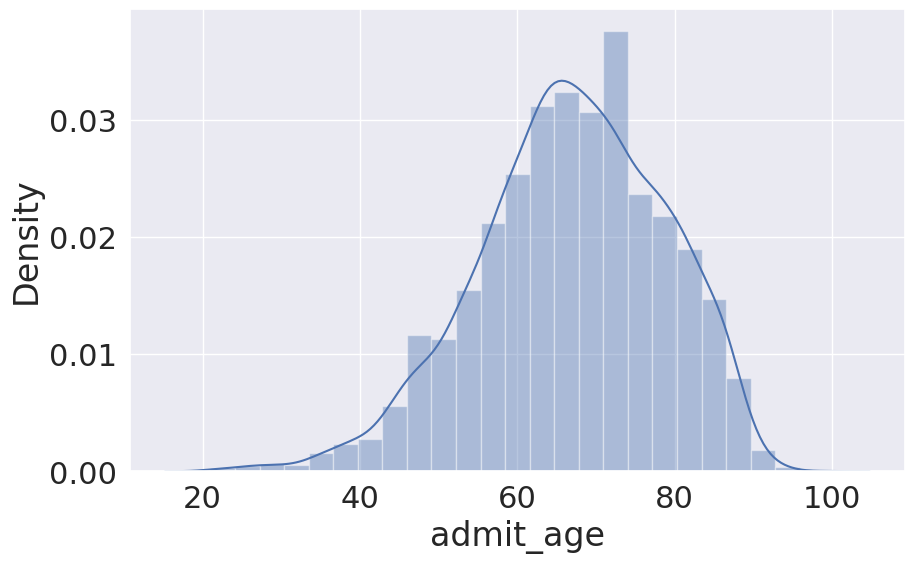

In [64]:
fig, ax = plt.subplots(figsize=(10,6))
 
sns.distplot(df_data['admit_age'], bins=25, ax=ax)
 
plt.show()

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

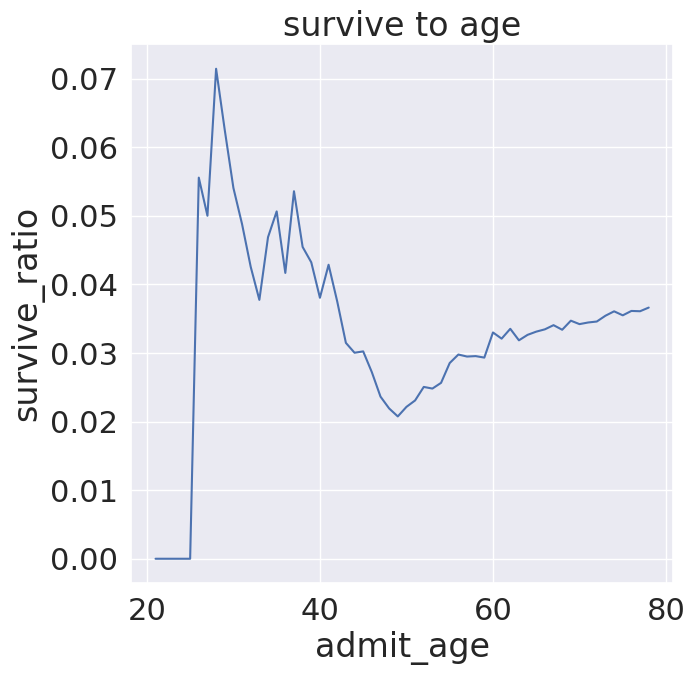

In [67]:
# 생존율을 입력받을 List 생성
age_range_survival_ratio = []
 
# 1살 부터 생존율 구하기
for i in range(1,80):
    age_range_survival_ratio.append(df_data[df_data['admit_age'] < i]['hospital_expire_flag'].sum() / len(df_data[df_data['admit_age'] < i]['hospital_expire_flag']))
 
plt.figure(figsize=(7,7))
plt.plot(age_range_survival_ratio)
plt.title('survive to age')
plt.ylabel('survive_ratio')
plt.xlabel('admit_age')
 
plt.show()